In [1]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 사원 퇴사 / 근속 데이터
-> 근무 중 인원, 퇴사 인원 파악

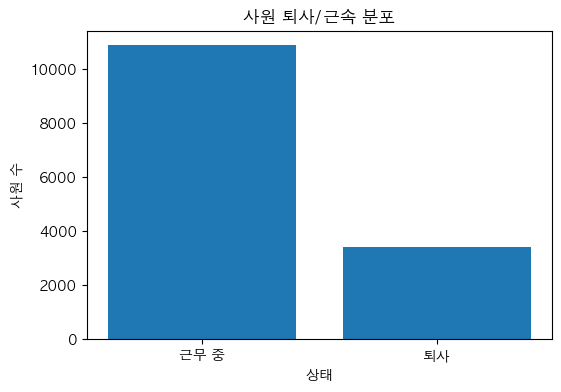

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import platform

# os 별 폰트 적용
if platform.system() == 'Darwin' :
    plt.rcParams["font.family"] = "AppleGothic"
else :
    plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
data = pd.read_csv('employee_churn.csv')

status = data['status'].value_counts()

plt.figure(figsize=(6, 4))

plt.bar(['근무 중', '퇴사'], status)
plt.title('사원 퇴사/근속 분포')
plt.xlabel('상태')
plt.ylabel('사원 수')
plt.show()

## 결측 값 처리

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

####################### 결측치 처리 ##########################

# 'department' 열의 결측치 삭제
if 'department' in data.columns:
    data = data.drop('department', axis=1)

# 'filed_complaint'과 'recently_promoted' 컬럼 데이터의 결측값을 0으로 채우기
data['filed_complaint'] = data['filed_complaint'].fillna(0)
data['recently_promoted'] = data['recently_promoted'].fillna(0)

# 'tenure'컬럼 데이터 근속 연수를 구하므로 결측값을 1으로 채우기
data['tenure'] = data['tenure'].fillna(1)

# 'last_evaluation', 'satisfaction' 결측치를 평균값으로 대체
data['last_evaluation'] = data['last_evaluation'].fillna(data['last_evaluation'].mean())
data['satisfaction'] = data['satisfaction'].fillna(data['satisfaction'].mean())

####################### 결측치 처리 끝 ##########################



#######################  Scaling 처리 #############################

# 수치형 데이터 Scaler
scaler = StandardScaler()
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# 범주형 변수를 Label Encoding으로 변환
categorical_columns = data.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  # 각 열의 인코더 저장 (나중에 해석 가능)

#######################  Scaling 처리 끝 #############################



#######################  trainset / testset 분리  #############################

X = data.drop('status', axis=1)  # 이탈 여부 열을 제외한 데이터
y = data['status']  # 이탈 여부 열만 선택

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#######################  trainset / testset 분리 끝  #############################

y

0        1
1        0
2        0
3        0
4        0
        ..
14244    0
14245    0
14246    1
14247    0
14248    0
Name: status, Length: 14249, dtype: int64

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay

# 성능 평가 함수 정의
def evaluate_model(model, X_test, y_test, title=None):
    y_pred = model.predict(X_test)
    print(f'============= {title} 모델 평가 지표 =============')
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print(f'=====================================================')


# 최적 모델을 평가하는 함수
def evaluate_and_visualize_model(model, X_test, y_test, title=None):
    # 예측 수행
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # 혼동 행렬
    print("혼동 행렬 : ")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{title} 모델 혼동 행렬')
    plt.show()

    # ROC 곡선 및 AUC 점수
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc_score = roc_auc_score(y_test, y_prob)
        plt.figure()
        plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()
    else:
        print("ROC Curve를 사용 할 수 없는 모델입니다.")

    # 특성 중요도 (랜덤 포레스트, 그라디언트 부스팅 등 트리 기반 모델만 해당)
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        features = X_test.columns
        indices = importances.argsort()[::-1]  # 중요도 순서로 정렬

        plt.figure(figsize=(10, 6))
        plt.title("특성 중요도")
        plt.bar(range(len(indices)), importances[indices], align="center")
        plt.xticks(range(len(indices)), [features[i] for i in indices], rotation=90)
        plt.show()
    else:
        print("특성 중요도를 사용할 수 없는 모델입니다")


In [ ]:
## 랜덤포레스트 모델

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier(random_state=0)  # 모델 생성
rf.fit(X_train, y_train) # 모델 학습
evaluate_model(rf, X_test, y_test, '랜덤 포레스트') # 모델 평가

# 랜덤 포레스트 하이퍼파라미터 튜닝 (RandomizedSearchCV)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# RandomizedSearchCV 활용
randomsearch = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=50, cv=3, n_jobs=-1, scoring='accuracy', random_state=0)
randomsearch.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 성능 출력
print("\n최적의 하이퍼파라미터 : ", randomsearch.best_params_,'\n')
bestrf = randomsearch.best_estimator_
evaluate_model(bestrf, X_test, y_test, '랜덤 포레스트 최적 하이퍼파라미터')

# 최종 평가: 최적화된 모델을 평가하고 시각적으로 분석
evaluate_and_visualize_model(bestrf, X_test, y_test, '랜덤 포레스트 최적 하이퍼파라미터') 

============= 랜덤 포레스트 모델 평가 지표 =============
Accuracy: 0.9824561403508771
Precision: 0.9780907668231612
Recall: 0.9455370650529501
F1 Score: 0.9615384615384616


In [21]:
import joblib

joblib.dump(rf, 'employee_churn_model.pkl')
print("Model saved as 'employee_churn_model.pkl'")

Model saved as 'employee_churn_model.pkl'


              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2189
           1       0.91      0.94      0.93       661

    accuracy                           0.97      2850
   macro avg       0.95      0.96      0.95      2850
weighted avg       0.97      0.97      0.97      2850

Accuracy: 0.9652631578947368
Precision: 0.9144542772861357
Recall: 0.9379727685325264
F1 Score: 0.9260642270351008
Confusion Matrix:


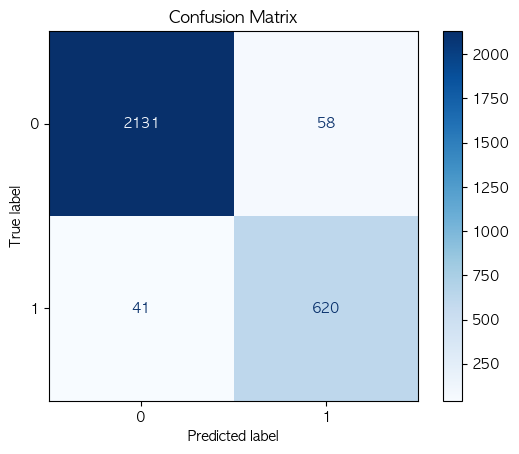

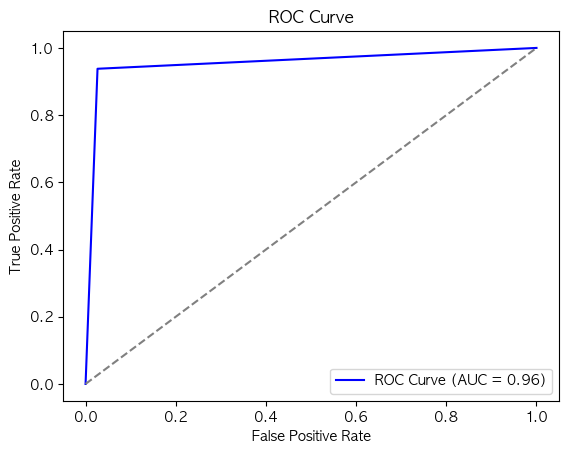

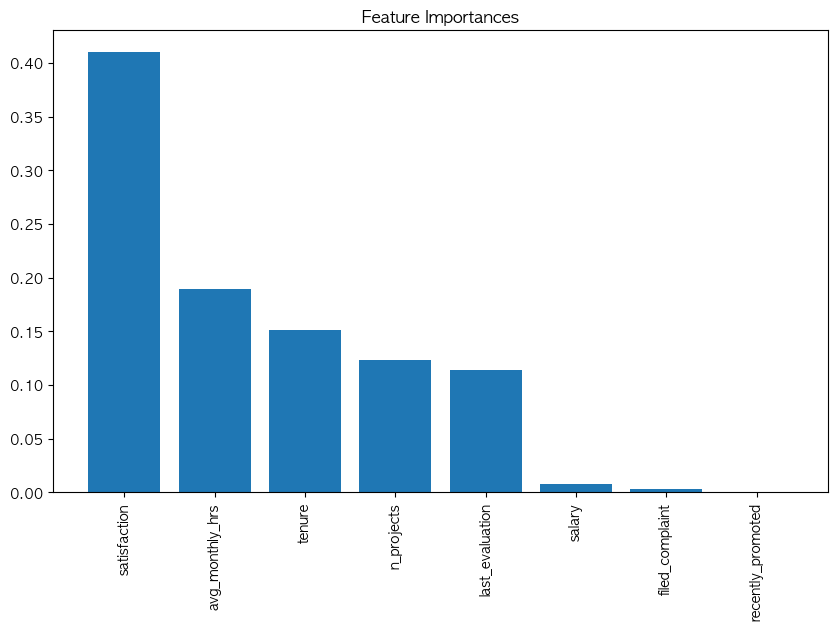

In [6]:
# Dicision Tree 모델
from sklearn.tree import DecisionTreeClassifier

model2 = DecisionTreeClassifier()
model2.fit(X_train, y_train)

pred_test = model2.predict(X_test)

evaluate_model(model2, X_test, y_test)

# 최종 평가: 최적화된 모델을 평가하고 시각적으로 분석
evaluate_and_visualize_model(model2, X_test, y_test)  # 'best_rf'는 최적화된 모델


In [3]:
# XGBoost 모델
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)

# 5. 예측 및 평가
y_pred = xgb_model.predict(X_test)

 # 분류 리포트 출력
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

def evaluate_model_performance(y_test, y_pred):
    # 정확도, 정밀도, 재현율, F1-스코어 계산
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # 성능 지표 출력
    print("Model Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
# 평가 함수 호출
evaluate_model_performance(y_test, y_pred)


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2189
           1       0.97      0.95      0.96       661

    accuracy                           0.98      2850
   macro avg       0.98      0.97      0.97      2850
weighted avg       0.98      0.98      0.98      2850

Model Performance:
Accuracy: 0.9818
Precision: 0.9721
Recall: 0.9486
F1 Score: 0.9602


Confusion Matrix:


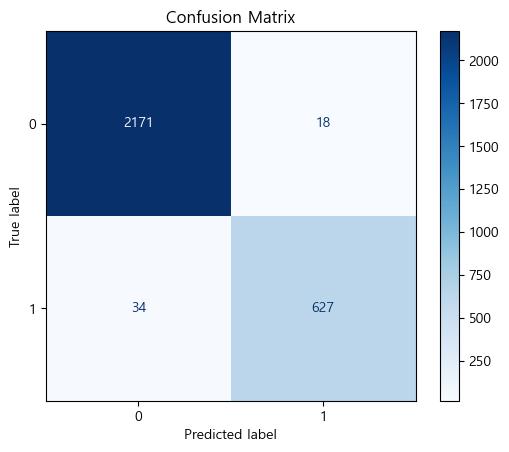

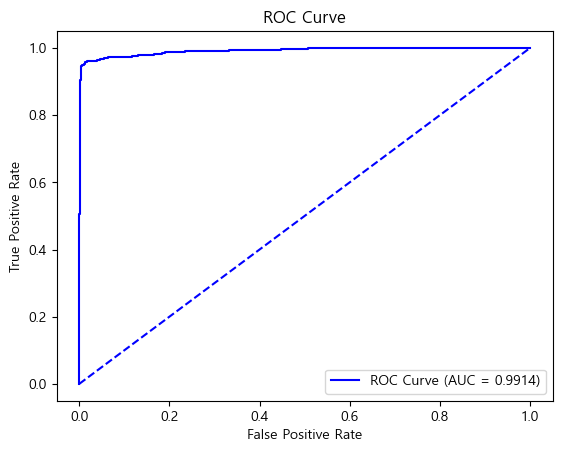

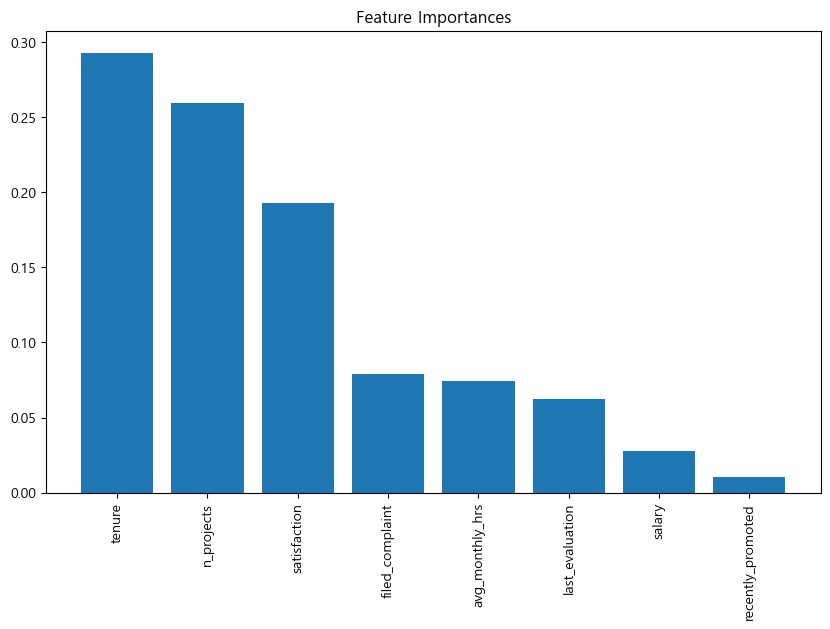

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay

# 최적 모델을 평가하는 함수
def evaluate_and_visualize_model(model, X_test, y_test):
    # 예측 수행
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # 혼동 행렬
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # ROC 곡선 및 AUC 점수
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc_score = roc_auc_score(y_test, y_prob)
        plt.figure()
        plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.4f})')
        plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()
    else:
        print("Model does not support probability prediction for ROC Curve.")

    # 특성 중요도 (랜덤 포레스트, 그라디언트 부스팅 등 트리 기반 모델만 해당)
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        features = X_test.columns
        indices = importances.argsort()[::-1]  # 중요도 순서로 정렬

        plt.figure(figsize=(10, 6))
        plt.title("Feature Importances")
        plt.bar(range(len(indices)), importances[indices], align="center")
        plt.xticks(range(len(indices)), [features[i] for i in indices], rotation=90)
        plt.show()
    else:
        print("Feature importance is not available for this model.")

# 최종 평가: 최적화된 모델을 평가하고 시각적으로 분석
evaluate_and_visualize_model(xgb_model, X_test, y_test)